In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

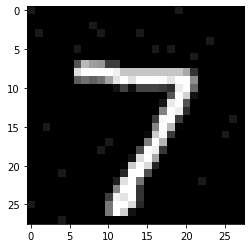

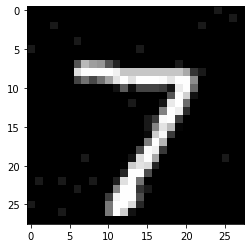

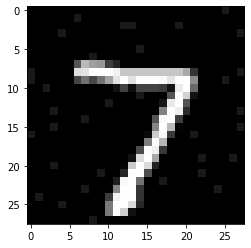

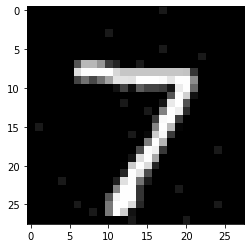

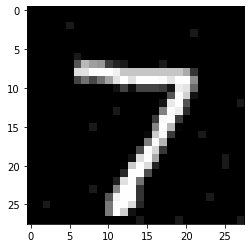

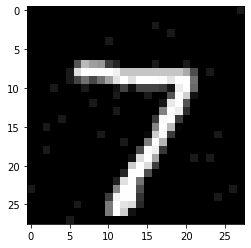

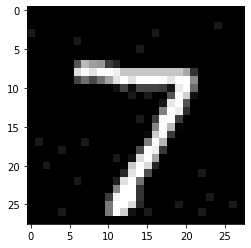

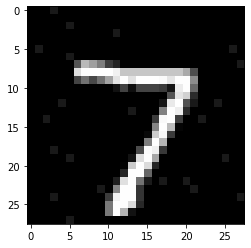

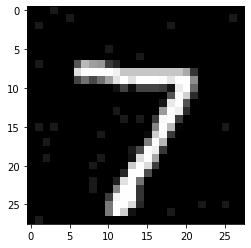

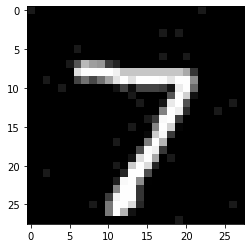

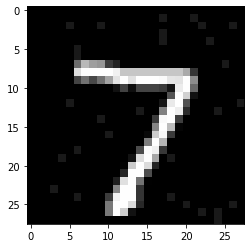

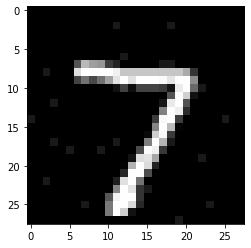

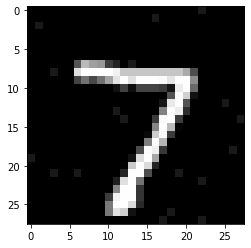

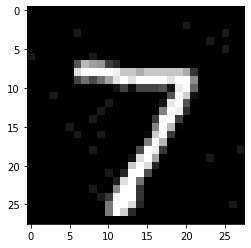

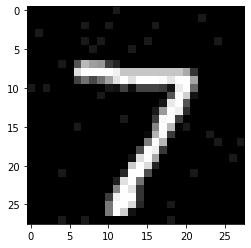

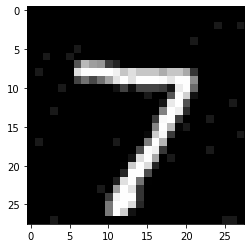

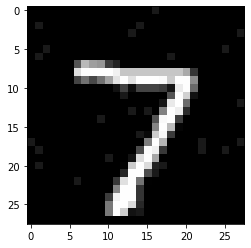

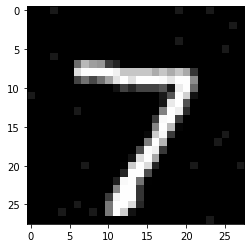

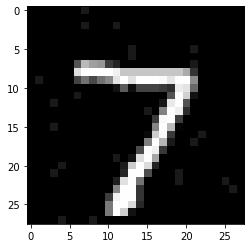

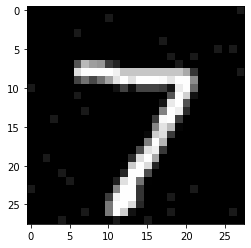

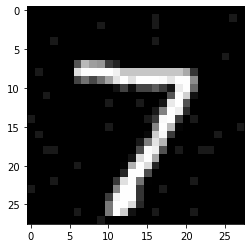

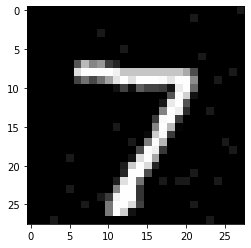

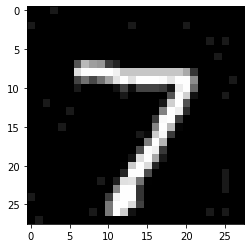

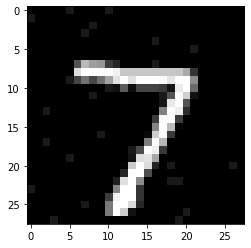

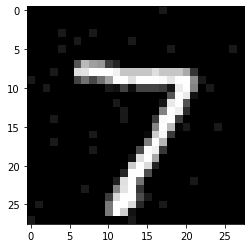

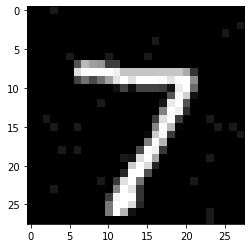

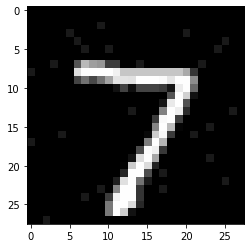

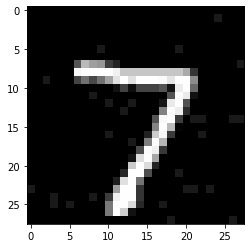

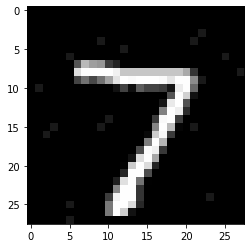

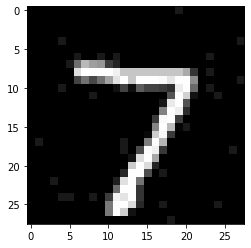

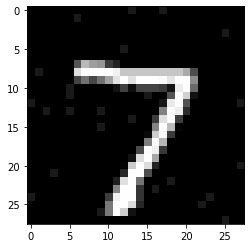

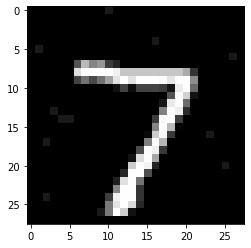

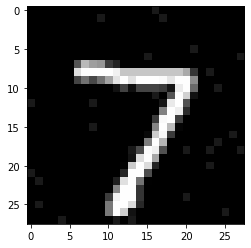

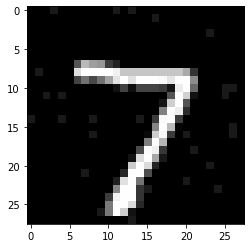

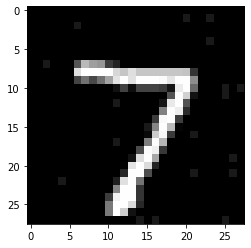

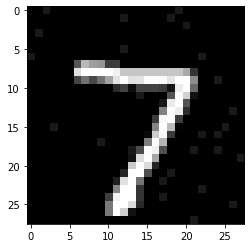

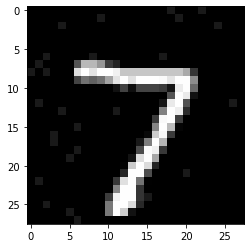

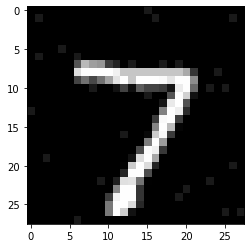

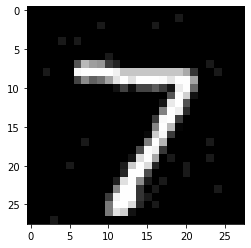

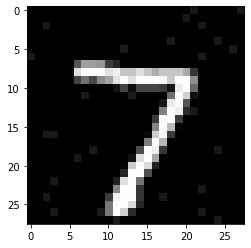

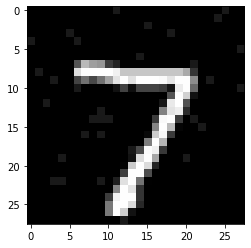

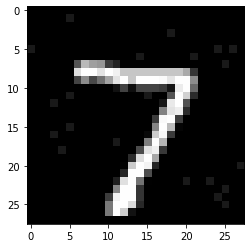

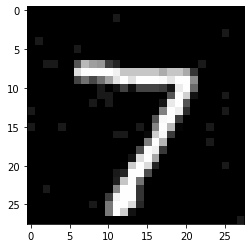

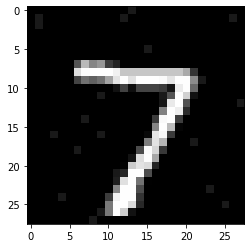

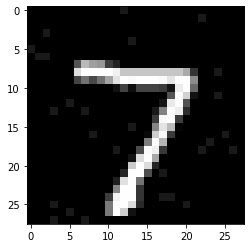

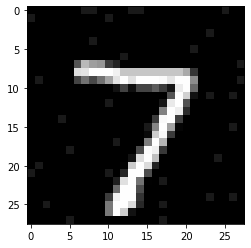

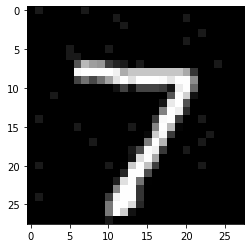

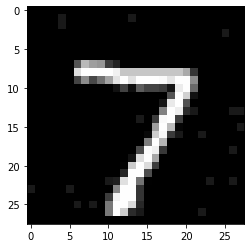

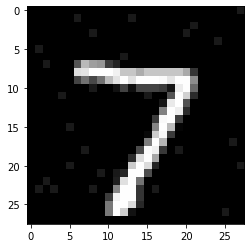

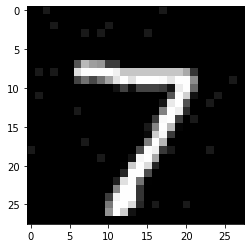

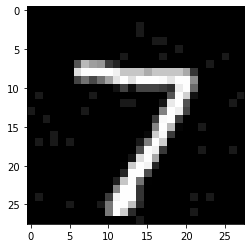

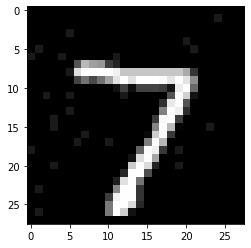

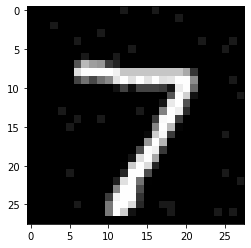

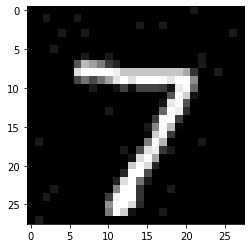

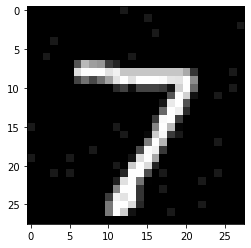

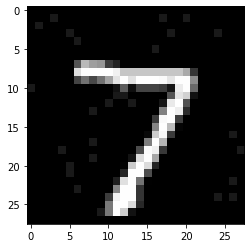

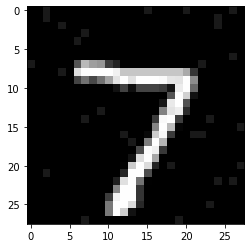

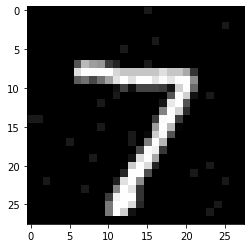

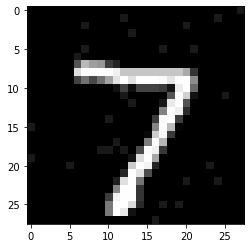

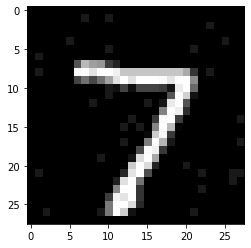

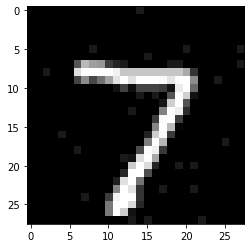

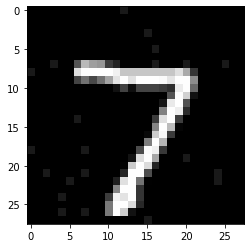

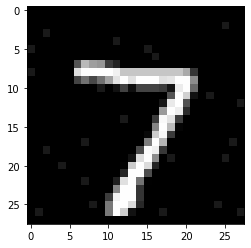

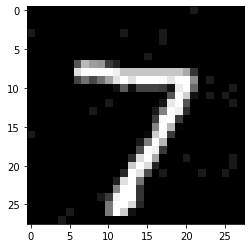

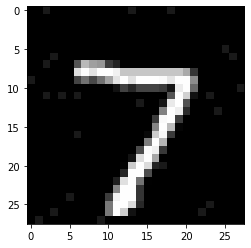

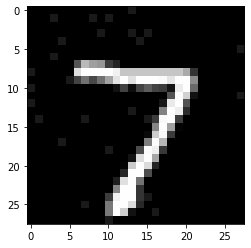

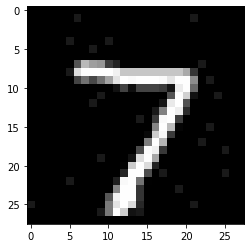

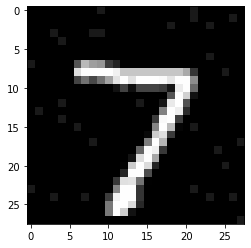

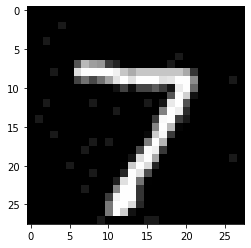

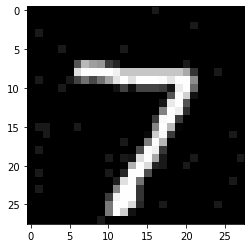

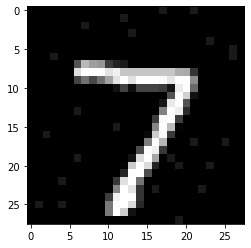

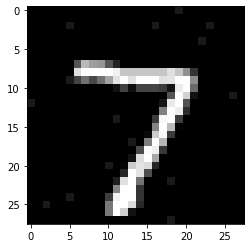

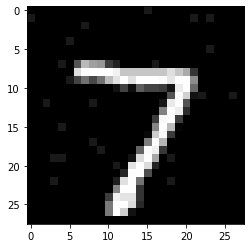

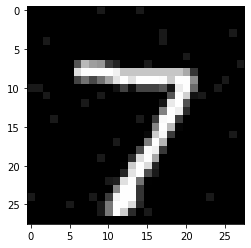

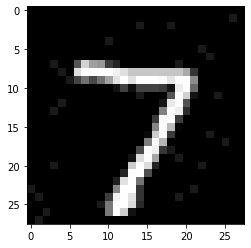

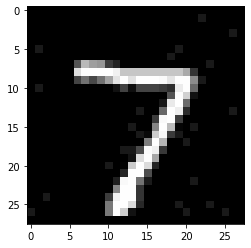

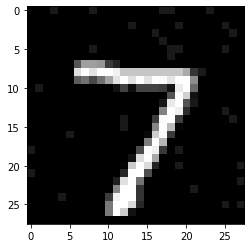

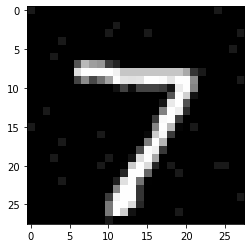

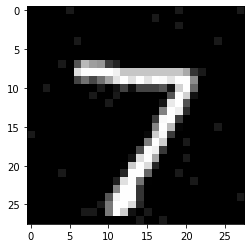

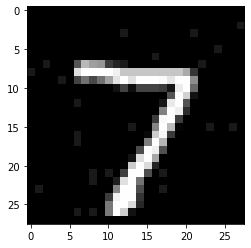

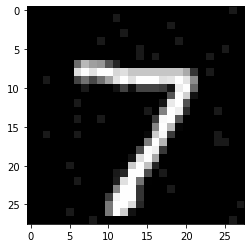

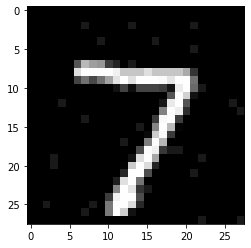

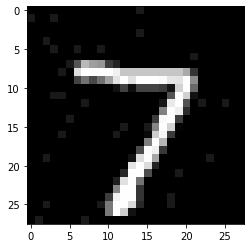

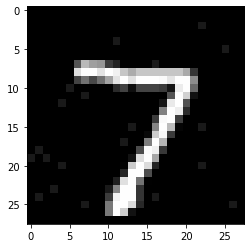

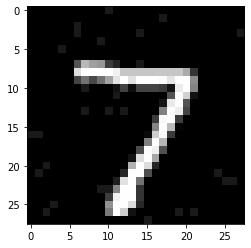

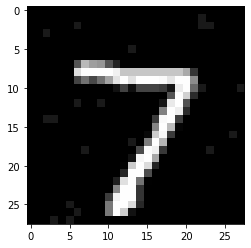

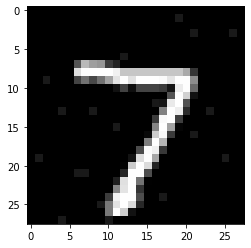

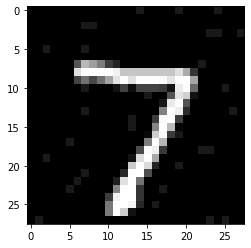

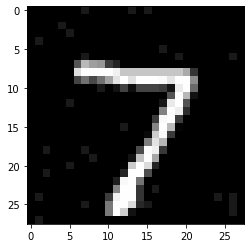

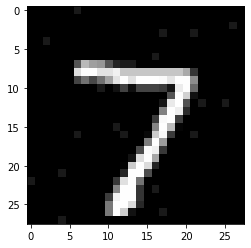

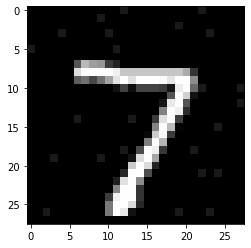

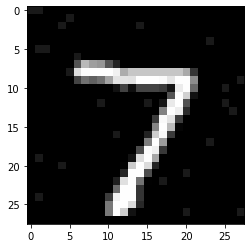

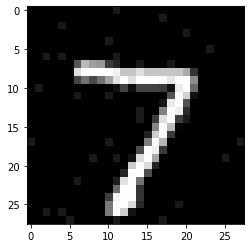

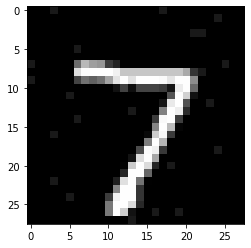

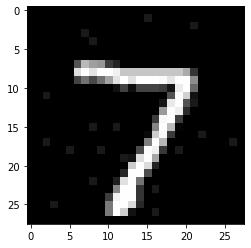

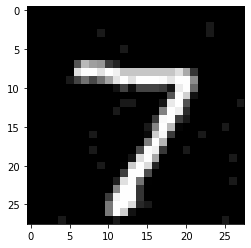

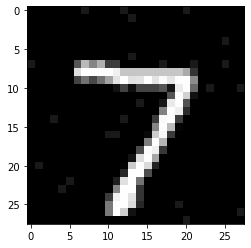

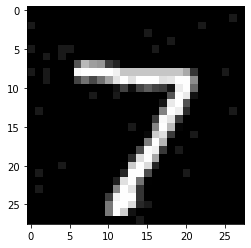

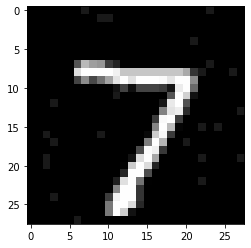

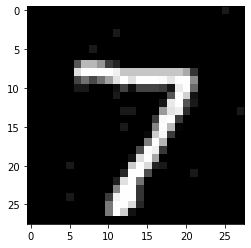

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [4]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [5]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [6]:
x_train = x_train / 255
x_test = x_test / 255 

In [7]:
model = load_model('mnist_model.h5')

In [8]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [9]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [11]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            Db[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Db ","最优值：", Func(Db),"扰动程度：",Dis(Db))
            best[:] = Db[:]
            if Func(best) > 0.45:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= 0.45:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")        
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= F:
                print("Resume")
                if D <= 5.0:
                    D += 0.3 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            Fb[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Fb ","最优值：", Func(Fb),"扰动程度：",Dis(Fb))
            best[:] = Fb[:]
            if Func(best) > 0.45:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Fb[:]
            
            if Func(BEST_X) <= 0.45:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")         
            if s == 1:
                best[:] = Fb[:]
            
            if Dis(BEST_X) <= D:
                print("Attack")
                if F > 0.3:
                    F -= 0.05
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [12]:
MAX_GENERATION = 2000  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.9   #置信度参数
D = 2.7   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "Attack")
re = Re(cond, "Resume")
best = 0
GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
Db = np.zeros(L)
Fb = np.zeros(L)
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
best = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()

Attack
最优值： 0.99670744 扰动程度： 0.3686629084967322 代数： 1
best  最优值： 0.99670744 扰动程度： 0.3686629084967322
 
最优值： 0.9966503 扰动程度： 0.3243054827141716 代数： 2
best  最优值： 0.9966503 扰动程度： 0.3243054827141716
 
最优值： 0.9965693 扰动程度： 0.3616628249973186 代数： 3
best  最优值： 0.9965693 扰动程度： 0.3616628249973186
 
最优值： 0.99646413 扰动程度： 0.377650948700684 代数： 4
best  最优值： 0.99646413 扰动程度： 0.377650948700684
 
最优值： 0.99641883 扰动程度： 0.37671965579745176 代数： 5
best  最优值： 0.99641883 扰动程度： 0.37671965579745176
 
最优值： 0.99642843 扰动程度： 0.3476996272023505 代数： 6
best  最优值： 0.99642843 扰动程度： 0.3476996272023505
 
最优值： 0.99635017 扰动程度： 0.36573268322580244 代数： 7
best  最优值： 0.99635017 扰动程度： 0.36573268322580244
 
最优值： 0.99632394 扰动程度： 0.3183072886488883 代数： 8
best  最优值： 0.99632394 扰动程度： 0.3183072886488883
 
最优值： 0.99621296 扰动程度： 0.3936577752896756 代数： 9
best  最优值： 0.99621296 扰动程度： 0.3936577752896756
 
最优值： 0.9960247 扰动程度： 0.3733173542954063 代数： 10
best  最优值： 0.9960247 扰动程度： 0.3733173542954063
 
最优值： 0.99601066 扰动程度： 0.381088253562

最优值： 0.970242 扰动程度： 1.9787930669883003 代数： 87
best  最优值： 0.970242 扰动程度： 1.9787930669883003
 
最优值： 0.96968293 扰动程度： 1.9454409602872522 代数： 88
best  最优值： 0.96968293 扰动程度： 1.9454409602872522
 
最优值： 0.96939105 扰动程度： 1.9513053823868636 代数： 89
best  最优值： 0.96939105 扰动程度： 1.9513053823868636
 
最优值： 0.9683214 扰动程度： 2.014421937798698 代数： 90
best  最优值： 0.9683214 扰动程度： 2.014421937798698
 
最优值： 0.96790296 扰动程度： 2.0407859633767083 代数： 91
best  最优值： 0.96790296 扰动程度： 2.0407859633767083
 
最优值： 0.9676203 扰动程度： 1.9764893720033756 代数： 92
best  最优值： 0.9676203 扰动程度： 1.9764893720033756
 
最优值： 0.96708906 扰动程度： 2.0014793960482398 代数： 93
best  最优值： 0.96708906 扰动程度： 2.0014793960482398
 
最优值： 0.9652573 扰动程度： 2.0806360714943337 代数： 94
best  最优值： 0.9652573 扰动程度： 2.0806360714943337
 
最优值： 0.9644364 扰动程度： 2.1305722558401547 代数： 95
best  最优值： 0.9644364 扰动程度： 2.1305722558401547
 
最优值： 0.96284896 扰动程度： 2.189539435442943 代数： 96
best  最优值： 0.96284896 扰动程度： 2.189539435442943
 
最优值： 0.96268743 扰动程度： 2.1767413904739707 代数： 9

最优值： 0.8674224 扰动程度： 4.165973877153539 代数： 173
best  最优值： 0.8674224 扰动程度： 4.165973877153539
 
最优值： 0.86347944 扰动程度： 4.1391167471372645 代数： 174
best  最优值： 0.86347944 扰动程度： 4.1391167471372645
 
最优值： 0.8604605 扰动程度： 4.232269155671735 代数： 175
best  最优值： 0.8604605 扰动程度： 4.232269155671735
 
最优值： 0.8580339 扰动程度： 4.202336013072718 代数： 176
best  最优值： 0.8580339 扰动程度： 4.202336013072718
 
最优值： 0.85657763 扰动程度： 4.208174525086761 代数： 177
best  最优值： 0.85657763 扰动程度： 4.208174525086761
 
最优值： 0.8552821 扰动程度： 4.2923753042003945 代数： 178
best  最优值： 0.8552821 扰动程度： 4.2923753042003945
 
最优值： 0.85336477 扰动程度： 4.32956747450393 代数： 179
best  最优值： 0.85336477 扰动程度： 4.32956747450393
 
最优值： 0.84892607 扰动程度： 4.344514101060158 代数： 180
best  最优值： 0.84892607 扰动程度： 4.344514101060158
 
Resume
最优值： 0.85834926 扰动程度： 4.197333515253713 代数： 181
best  最优值： 0.85834926 扰动程度： 4.197333515253713
 
最优值： 0.86692303 扰动程度： 4.099497036044432 代数： 182
best  最优值： 0.86692303 扰动程度： 4.099497036044432
 
最优值： 0.87668914 扰动程度： 3.998353385900192

最优值： 0.85073984 扰动程度： 4.035462741133786 代数： 259
best  最优值： 0.85073984 扰动程度： 4.035462741133786
 
最优值： 0.8465827 扰动程度： 4.134706225251706 代数： 260
best  最优值： 0.8465827 扰动程度： 4.134706225251706
 
最优值： 0.8389923 扰动程度： 4.182888946895559 代数： 261
best  最优值： 0.8389923 扰动程度： 4.182888946895559
 
最优值： 0.83503973 扰动程度： 4.281272145163958 代数： 262
best  最优值： 0.83503973 扰动程度： 4.281272145163958
 
最优值： 0.8362526 扰动程度： 4.23981660344052 代数： 263
best  最优值： 0.8362526 扰动程度： 4.23981660344052
 
最优值： 0.82578963 扰动程度： 4.330797202391567 代数： 264
best  最优值： 0.82578963 扰动程度： 4.330797202391567
 
最优值： 0.82357377 扰动程度： 4.356701427913826 代数： 265
best  最优值： 0.82357377 扰动程度： 4.356701427913826
 
最优值： 0.82031924 扰动程度： 4.402901270201699 代数： 266
best  最优值： 0.82031924 扰动程度： 4.402901270201699
 
最优值： 0.81905097 扰动程度： 4.4698923225776825 代数： 267
best  最优值： 0.81905097 扰动程度： 4.4698923225776825
 
最优值： 0.8183896 扰动程度： 4.513720347282356 代数： 268
best  最优值： 0.8183896 扰动程度： 4.513720347282356
 
最优值： 0.80852354 扰动程度： 4.571192374979989 代数： 269


最优值： 0.6949906 扰动程度： 5.43601588791761 代数： 346
best  最优值： 0.6949906 扰动程度： 5.43601588791761
 
Resume
最优值： 0.7019519 扰动程度： 5.320595914485546 代数： 347
best  最优值： 0.7019519 扰动程度： 5.320595914485546
 
最优值： 0.70951986 扰动程度： 5.246756461895399 代数： 348
best  最优值： 0.70951986 扰动程度： 5.246756461895399
 
最优值： 0.719227 扰动程度： 5.210892670733739 代数： 349
best  最优值： 0.719227 扰动程度： 5.210892670733739
 
最优值： 0.72777694 扰动程度： 5.079160510413092 代数： 350
best  最优值： 0.72777694 扰动程度： 5.079160510413092
 
最优值： 0.73274374 扰动程度： 4.987699190279557 代数： 351
best  最优值： 0.73274374 扰动程度： 4.987699190279557
 
最优值： 0.7385277 扰动程度： 4.836644364780215 代数： 352
best  最优值： 0.7385277 扰动程度： 4.836644364780215
 
最优值： 0.73868847 扰动程度： 4.828896143596733 代数： 353
best  最优值： 0.73868847 扰动程度： 4.828896143596733
 
最优值： 0.7450053 扰动程度： 4.767046625717515 代数： 354
best  最优值： 0.7450053 扰动程度： 4.767046625717515
 
最优值： 0.74904007 扰动程度： 4.738808148622353 代数： 355
best  最优值： 0.74904007 扰动程度： 4.738808148622353
 
最优值： 0.7503181 扰动程度： 4.727294801290606 代数： 356


最优值： 0.7214048 扰动程度： 4.814118882774138 代数： 433
best  最优值： 0.7214048 扰动程度： 4.814118882774138
 
最优值： 0.7205265 扰动程度： 4.821656658235228 代数： 434
best  最优值： 0.7205265 扰动程度： 4.821656658235228
 
最优值： 0.7144508 扰动程度： 4.844881719284978 代数： 435
best  最优值： 0.7144508 扰动程度： 4.844881719284978
 
最优值： 0.71396744 扰动程度： 4.936790967480001 代数： 436
best  最优值： 0.71396744 扰动程度： 4.936790967480001
 
最优值： 0.7074786 扰动程度： 4.990154622479558 代数： 437
best  最优值： 0.7074786 扰动程度： 4.990154622479558
 
最优值： 0.69567657 扰动程度： 5.046001140269004 代数： 438
best  最优值： 0.69567657 扰动程度： 5.046001140269004
 
最优值： 0.6959785 扰动程度： 5.097328609142077 代数： 439
best  最优值： 0.6959785 扰动程度： 5.097328609142077
 
最优值： 0.6938461 扰动程度： 5.019014967813245 代数： 440
best  最优值： 0.6938461 扰动程度： 5.019014967813245
 
最优值： 0.69152886 扰动程度： 5.039705509671652 代数： 441
best  最优值： 0.69152886 扰动程度： 5.039705509671652
 
最优值： 0.69072515 扰动程度： 5.078338096624427 代数： 442
best  最优值： 0.69072515 扰动程度： 5.078338096624427
 
最优值： 0.6879573 扰动程度： 5.103735073192017 代数： 443
best 

最优值： 0.610586 扰动程度： 5.549699033940118 代数： 520
best  最优值： 0.610586 扰动程度： 5.549699033940118
 
最优值： 0.6199843 扰动程度： 5.51210321883173 代数： 521
best  最优值： 0.6199843 扰动程度： 5.51210321883173
 
最优值： 0.62799156 扰动程度： 5.42655803482358 代数： 522
best  最优值： 0.62799156 扰动程度： 5.42655803482358
 
最优值： 0.6308227 扰动程度： 5.34986161283 代数： 523
best  最优值： 0.6308227 扰动程度： 5.34986161283
 
最优值： 0.6370962 扰动程度： 5.300020411803816 代数： 524
best  最优值： 0.6370962 扰动程度： 5.300020411803816
 
最优值： 0.6399408 扰动程度： 5.289156058497183 代数： 525
best  最优值： 0.6399408 扰动程度： 5.289156058497183
 
最优值： 0.64003134 扰动程度： 5.24978415028347 代数： 526
best  最优值： 0.64003134 扰动程度： 5.24978415028347
 
最优值： 0.6368595 扰动程度： 5.283332000786959 代数： 527
best  最优值： 0.6368595 扰动程度： 5.283332000786959
 
最优值： 0.6454113 扰动程度： 5.2202952288759255 代数： 528
best  最优值： 0.6454113 扰动程度： 5.2202952288759255
 
最优值： 0.6545216 扰动程度： 5.182754542745624 代数： 529
best  最优值： 0.6545216 扰动程度： 5.182754542745624
 
最优值： 0.65500253 扰动程度： 5.127124898659395 代数： 530
best  最优值： 0.65500253 

最优值： 0.50974035 扰动程度： 6.086318664387474 代数： 607
best  最优值： 0.50974035 扰动程度： 6.086318664387474
 
最优值： 0.5023337 扰动程度： 6.169962744114634 代数： 608
best  最优值： 0.5023337 扰动程度： 6.169962744114634
 
最优值： 0.4993049 扰动程度： 6.190608045844118 代数： 609
best  最优值： 0.4993049 扰动程度： 6.190608045844118
 
最优值： 0.49244514 扰动程度： 6.239748095683608 代数： 610
best  最优值： 0.49244514 扰动程度： 6.239748095683608
 
最优值： 0.4919324 扰动程度： 6.30616550428439 代数： 611
best  最优值： 0.4919324 扰动程度： 6.30616550428439
 
最优值： 0.4889121 扰动程度： 6.404558109871022 代数： 612
best  最优值： 0.4889121 扰动程度： 6.404558109871022
 
最优值： 0.47087786 扰动程度： 6.503764845061548 代数： 613
best  最优值： 0.47087786 扰动程度： 6.503764845061548
 
最优值： 0.46943977 扰动程度： 6.497582740631355 代数： 614
best  最优值： 0.46943977 扰动程度： 6.497582740631355
 
最优值： 0.46128982 扰动程度： 6.5736076217455714 代数： 615
best  最优值： 0.46128982 扰动程度： 6.5736076217455714
 
最优值： 0.45982018 扰动程度： 6.585085730286775 代数： 616
best  最优值： 0.45982018 扰动程度： 6.585085730286775
 
最优值： 0.45328978 扰动程度： 6.63702115329363 代数： 617
b

最优值： 0.44751367 扰动程度： 6.282273976112145 代数： 759
 
最优值： 0.43751922 扰动程度： 6.3781370330820994 代数： 760
best  最优值： 0.43751922 扰动程度： 6.3781370330820994
 
最优值： 0.43391097 扰动程度： 6.37677052771762 代数： 761
best  最优值： 0.43391097 扰动程度： 6.37677052771762
 
最优值： 0.428627 扰动程度： 6.414584994605901 代数： 762
 
最优值： 0.42808723 扰动程度： 6.449061665818363 代数： 763
 
最优值： 0.42475906 扰动程度： 6.439835656214435 代数： 764
 
最优值： 0.4198254 扰动程度： 6.521646785417278 代数： 765
 
最优值： 0.4103886 扰动程度： 6.646323354203377 代数： 766
 
最优值： 0.39922127 扰动程度： 6.7034964530490555 代数： 767
 
最优值： 0.3955999 扰动程度： 6.732182687786794 代数： 768
 
最优值： 0.383859 扰动程度： 6.7610348225392 代数： 769
 
最优值： 0.3836544 扰动程度： 6.813962246957236 代数： 770
 
最优值： 0.375732 扰动程度： 6.90277420813067 代数： 771
 
最优值： 0.37000152 扰动程度： 6.934463904341077 代数： 772
 
最优值： 0.36126983 扰动程度： 6.937126102380353 代数： 773
 
最优值： 0.35817876 扰动程度： 6.961920783379954 代数： 774
 
最优值： 0.35991552 扰动程度： 7.036505052606633 代数： 775
 
最优值： 0.35666063 扰动程度： 7.051447513424456 代数： 776
 
最优值： 0.35400215 扰动程度

最优值： 0.53736466 扰动程度： 5.4515065907422375 代数： 921
 
最优值： 0.5410282 扰动程度： 5.353720808666253 代数： 922
 
最优值： 0.5441366 扰动程度： 5.330649378039838 代数： 923
 
最优值： 0.5436075 扰动程度： 5.3398043511252045 代数： 924
 
最优值： 0.5507603 扰动程度： 5.3022130005865264 代数： 925
 
最优值： 0.55447966 扰动程度： 5.316016062837957 代数： 926
 
最优值： 0.5562854 扰动程度： 5.25679599972366 代数： 927
 
最优值： 0.5663625 扰动程度： 5.202186474175351 代数： 928
 
最优值： 0.57122314 扰动程度： 5.205530815636074 代数： 929
 
最优值： 0.5727642 扰动程度： 5.155463670722321 代数： 930
 
最优值： 0.57673454 扰动程度： 5.10986536878565 代数： 931
 
最优值： 0.58183604 扰动程度： 5.084258115062883 代数： 932
 
Attack
最优值： 0.56937736 扰动程度： 5.150714927013297 代数： 933
 
最优值： 0.55682224 扰动程度： 5.23956649668415 代数： 934
 
最优值： 0.5441338 扰动程度： 5.332986421516101 代数： 935
 
最优值： 0.5279553 扰动程度： 5.392092315206888 代数： 936
 
最优值： 0.52757853 扰动程度： 5.489966781845952 代数： 937
 
最优值： 0.51708674 扰动程度： 5.5175782735469365 代数： 938
 
最优值： 0.50754577 扰动程度： 5.60047551744894 代数： 939
 
最优值： 0.49321607 扰动程度： 5.700357606861629 代数： 940
 
最优

最优值： 0.3931124 扰动程度： 6.336679523751163 代数： 1084
 
最优值： 0.39384073 扰动程度： 6.2674830431257185 代数： 1085
 
最优值： 0.40344602 扰动程度： 6.228761071784946 代数： 1086
 
最优值： 0.40657437 扰动程度： 6.1682170182266045 代数： 1087
 
最优值： 0.4090359 扰动程度： 6.1503632873825405 代数： 1088
 
最优值： 0.41342282 扰动程度： 6.129472569478821 代数： 1089
 
最优值： 0.42100573 扰动程度： 6.0989902269896445 代数： 1090
 
最优值： 0.43076208 扰动程度： 6.0707712913636245 代数： 1091
 
最优值： 0.43376735 扰动程度： 5.967109300103791 代数： 1092
 
最优值： 0.4347088 扰动程度： 5.959674140486705 代数： 1093
 
最优值： 0.4436629 扰动程度： 5.951770006257786 代数： 1094
 
最优值： 0.45290518 扰动程度： 5.8436429385742965 代数： 1095
 
最优值： 0.4611424 扰动程度： 5.788513062707798 代数： 1096
 
最优值： 0.46959156 扰动程度： 5.731160730312678 代数： 1097
 
最优值： 0.46733218 扰动程度： 5.728535474868595 代数： 1098
 
最优值： 0.4702955 扰动程度： 5.711045385650945 代数： 1099
 
最优值： 0.47983304 扰动程度： 5.628729781636576 代数： 1100
 
最优值： 0.4831713 扰动程度： 5.605011849817766 代数： 1101
 
最优值： 0.48952535 扰动程度： 5.597460953097195 代数： 1102
 
最优值： 0.49915785 扰动程度： 5.53463381

最优值： 0.38127446 扰动程度： 6.156633967083479 代数： 1243
 
最优值： 0.3871383 扰动程度： 6.0786614156344205 代数： 1244
 
最优值： 0.39201754 扰动程度： 6.04632801421482 代数： 1245
 
最优值： 0.40023902 扰动程度： 5.958811362571809 代数： 1246
 
最优值： 0.4066698 扰动程度： 5.975078015927683 代数： 1247
 
最优值： 0.40550286 扰动程度： 5.952387060559211 代数： 1248
 
最优值： 0.40847266 扰动程度： 5.906529922682559 代数： 1249
 
最优值： 0.41505906 扰动程度： 5.871033280235457 代数： 1250
 
最优值： 0.42466664 扰动程度： 5.8286364660953875 代数： 1251
 
最优值： 0.43059888 扰动程度： 5.766010835677905 代数： 1252
 
最优值： 0.43993646 扰动程度： 5.691261745529076 代数： 1253
 
最优值： 0.44859692 扰动程度： 5.64525777471793 代数： 1254
 
最优值： 0.45650968 扰动程度： 5.632544834829268 代数： 1255
 
最优值： 0.45376846 扰动程度： 5.6093345400065555 代数： 1256
 
最优值： 0.45683086 扰动程度： 5.590605688042056 代数： 1257
 
最优值： 0.46383542 扰动程度： 5.571185592671718 代数： 1258
 
最优值： 0.47199753 扰动程度： 5.521982427216312 代数： 1259
 
最优值： 0.47990352 扰动程度： 5.4768594376592485 代数： 1260
 
最优值： 0.48833215 扰动程度： 5.397763849930819 代数： 1261
 
最优值： 0.49981755 扰动程度： 5.3450832

最优值： 0.43834984 扰动程度： 5.6421147821556525 代数： 1403
 
最优值： 0.44372192 扰动程度： 5.608573031926338 代数： 1404
 
最优值： 0.45226103 扰动程度： 5.539351856026785 代数： 1405
 
最优值： 0.4507766 扰动程度： 5.498584853478787 代数： 1406
 
最优值： 0.45968577 扰动程度： 5.490685529977744 代数： 1407
 
最优值： 0.4580258 扰动程度： 5.459111172018108 代数： 1408
 
最优值： 0.46407086 扰动程度： 5.472787284700791 代数： 1409
 
最优值： 0.46649042 扰动程度： 5.423840423439463 代数： 1410
 
最优值： 0.47461298 扰动程度： 5.408539133006961 代数： 1411
 
最优值： 0.4832673 扰动程度： 5.337716711123762 代数： 1412
 
最优值： 0.48190755 扰动程度： 5.347221966957072 代数： 1413
 
最优值： 0.48686567 扰动程度： 5.329447302172488 代数： 1414
 
最优值： 0.48657706 扰动程度： 5.2919727313870615 代数： 1415
 
最优值： 0.48606873 扰动程度： 5.27619807533955 代数： 1416
 
最优值： 0.4853026 扰动程度： 5.275766108071231 代数： 1417
 
最优值： 0.4945163 扰动程度： 5.239436061048251 代数： 1418
 
最优值： 0.5007811 扰动程度： 5.229241019215237 代数： 1419
 
最优值： 0.50344604 扰动程度： 5.219735325649203 代数： 1420
 
最优值： 0.5130505 扰动程度： 5.166839364375129 代数： 1421
 
最优值： 0.52268416 扰动程度： 5.1500373083643

最优值： 0.3981198 扰动程度： 5.913050588149538 代数： 1564
 
最优值： 0.38938865 扰动程度： 5.9262463844269035 代数： 1565
 
最优值： 0.3822711 扰动程度： 6.019177364728045 代数： 1566
 
最优值： 0.37409896 扰动程度： 6.047213904394083 代数： 1567
 
最优值： 0.37191945 扰动程度： 6.085350349366632 代数： 1568
 
最优值： 0.3635138 扰动程度： 6.134461127937989 代数： 1569
 
最优值： 0.3520975 扰动程度： 6.222739664633741 代数： 1570
 
最优值： 0.3416462 扰动程度： 6.2982334280433685 代数： 1571
 
最优值： 0.34091106 扰动程度： 6.304165068503158 代数： 1572
 
最优值： 0.33222955 扰动程度： 6.37571684716851 代数： 1573
 
最优值： 0.32255134 扰动程度： 6.450757699254911 代数： 1574
 
最优值： 0.32073736 扰动程度： 6.47506052941986 代数： 1575
 
最优值： 0.31560364 扰动程度： 6.496818460189991 代数： 1576
 
最优值： 0.31060383 扰动程度： 6.590167573275125 代数： 1577
 
最优值： 0.30137283 扰动程度： 6.646264992956317 代数： 1578
 
最优值： 0.29960105 扰动程度： 6.66467030562668 代数： 1579
 
Resume
最优值： 0.29972985 扰动程度： 6.6639881374833205 代数： 1580
 
最优值： 0.3053831 扰动程度： 6.655799897799036 代数： 1581
 
最优值： 0.31376457 扰动程度： 6.547542115452862 代数： 1582
 
最优值： 0.32321736 扰动程度： 6.357773

最优值： 0.4128867 扰动程度： 5.666673367567174 代数： 1723
 
最优值： 0.40910286 扰动程度： 5.659411740202492 代数： 1724
 
最优值： 0.4096628 扰动程度： 5.652024970971767 代数： 1725
 
最优值： 0.41215897 扰动程度： 5.643605815478513 代数： 1726
 
最优值： 0.41683552 扰动程度： 5.622109027889677 代数： 1727
 
最优值： 0.42116112 扰动程度： 5.589507805405092 代数： 1728
 
最优值： 0.43116045 扰动程度： 5.524486817984976 代数： 1729
 
最优值： 0.43102333 扰动程度： 5.512341676779744 代数： 1730
 
最优值： 0.4376654 扰动程度： 5.49831659091989 代数： 1731
 
最优值： 0.45028144 扰动程度： 5.417262268701917 代数： 1732
 
最优值： 0.45806223 扰动程度： 5.412493620668188 代数： 1733
 
最优值： 0.46243265 扰动程度： 5.366102486410276 代数： 1734
 
最优值： 0.47173056 扰动程度： 5.292138096657832 代数： 1735
 
最优值： 0.47419387 扰动程度： 5.302181174348343 代数： 1736
 
最优值： 0.47813746 扰动程度： 5.21423126163367 代数： 1737
 
最优值： 0.47862282 扰动程度： 5.226272199702215 代数： 1738
 
最优值： 0.4867825 扰动程度： 5.207964776738425 代数： 1739
 
最优值： 0.48948273 扰动程度： 5.194096413952787 代数： 1740
 
最优值： 0.4917703 扰动程度： 5.143377808077196 代数： 1741
 
最优值： 0.49076456 扰动程度： 5.15402380888116

最优值： 0.32103497 扰动程度： 6.267539107105444 代数： 1883
 
最优值： 0.31900764 扰动程度： 6.293078472739445 代数： 1884
 
最优值： 0.30318138 扰动程度： 6.3896073549445855 代数： 1885
 
最优值： 0.2992348 扰动程度： 6.44046121763637 代数： 1886
 
Resume
最优值： 0.30333 扰动程度： 6.377011939589035 代数： 1887
 
最优值： 0.31048894 扰动程度： 6.352573563244626 代数： 1888
 
最优值： 0.32041034 扰动程度： 6.23326274268316 代数： 1889
 
最优值： 0.326195 扰动程度： 6.138868551062707 代数： 1890
 
最优值： 0.33544153 扰动程度： 6.100356450173518 代数： 1891
 
最优值： 0.33344376 扰动程度： 6.065446231888041 代数： 1892
 
最优值： 0.3413236 扰动程度： 6.02941912480033 代数： 1893
 
最优值： 0.34801936 扰动程度： 6.021528661680393 代数： 1894
 
最优值： 0.35525054 扰动程度： 5.935677216251772 代数： 1895
 
最优值： 0.35791466 扰动程度： 5.820109216924777 代数： 1896
 
最优值： 0.35913676 扰动程度： 5.81674872002559 代数： 1897
 
最优值： 0.3648511 扰动程度： 5.8089853569093615 代数： 1898
 
最优值： 0.3719964 扰动程度： 5.7834820545370365 代数： 1899
 
最优值： 0.37975794 扰动程度： 5.7551765062335525 代数： 1900
 
最优值： 0.3824193 扰动程度： 5.74149899261164 代数： 1901
 
最优值： 0.38518125 扰动程度： 5.68029007954

In [13]:
best

array([ 0.00000000e+00,  0.00000000e+00,  9.28179977e-03,  1.73382147e-02,
        0.00000000e+00,  9.61545862e-04,  0.00000000e+00,  4.86337181e-03,
        7.42511058e-04,  1.01719910e-02,  2.76912161e-05,  0.00000000e+00,
       -0.00000000e+00,  1.41890932e-04, -0.00000000e+00,  3.43856784e-04,
        8.57253545e-04,  2.45283589e-03,  8.01926551e-02,  3.92075962e-02,
        1.44267872e-01,  0.00000000e+00,  4.00800003e-02,  3.35557133e-03,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  1.23094332e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.97708836e-04,  3.36193596e-01,  0.00000000e+00,  0.00000000e+00,
        1.86302678e-01,  1.43343353e-02,  0.00000000e+00,  0.00000000e+00,
        8.12615493e-02,  5.82417045e-04,  7.03592400e-03,  0.00000000e+00,
        5.34831945e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  

In [14]:
print("最优值：", Func(best),"扰动程度：",Dis(best))

最优值： 0.35122252 扰动程度： 5.848437421034575


In [10]:
best=np.array([ 0.00000000e+00,  0.00000000e+00,  9.28179977e-03,  1.73382147e-02,
        0.00000000e+00,  9.61545862e-04,  0.00000000e+00,  4.86337181e-03,
        7.42511058e-04,  1.01719910e-02,  2.76912161e-05,  0.00000000e+00,
       -0.00000000e+00,  1.41890932e-04, -0.00000000e+00,  3.43856784e-04,
        8.57253545e-04,  2.45283589e-03,  8.01926551e-02,  3.92075962e-02,
        1.44267872e-01,  0.00000000e+00,  4.00800003e-02,  3.35557133e-03,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  1.23094332e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.97708836e-04,  3.36193596e-01,  0.00000000e+00,  0.00000000e+00,
        1.86302678e-01,  1.43343353e-02,  0.00000000e+00,  0.00000000e+00,
        8.12615493e-02,  5.82417045e-04,  7.03592400e-03,  0.00000000e+00,
        5.34831945e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  5.18894801e-06,  0.00000000e+00,
        0.00000000e+00,  1.82393481e-08,  0.00000000e+00,  0.00000000e+00,
        5.08251097e-05,  1.20168565e-02,  0.00000000e+00,  0.00000000e+00,
        8.06506489e-06,  0.00000000e+00,  0.00000000e+00,  3.95269935e-03,
        0.00000000e+00,  1.97152165e-02,  9.31778413e-06,  0.00000000e+00,
        3.84511296e-02,  0.00000000e+00,  4.89026382e-04,  4.84006354e-04,
        0.00000000e+00,  2.71273251e-05,  1.43937852e-04,  0.00000000e+00,
        2.61416572e-03,  1.04199650e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.04239317e-02, -0.00000000e+00,  0.00000000e+00,
        8.87711174e-05,  3.75763836e-03,  2.39403031e-04,  1.55564719e-02,
        0.00000000e+00,  2.08469997e-04,  2.49843178e-02,  0.00000000e+00,
        0.00000000e+00,  1.84430151e-02,  0.00000000e+00, -0.00000000e+00,
        1.33869193e-01,  4.46968028e-06,  6.11255908e-03,  0.00000000e+00,
        7.02665119e-03,  0.00000000e+00,  0.00000000e+00,  2.94853595e-02,
        0.00000000e+00,  0.00000000e+00,  7.39946048e-06,  0.00000000e+00,
        1.06578679e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.34394448e-06,  6.93280402e-06,  8.35035739e-02,  4.74369226e-03,
        0.00000000e+00,  3.93117631e-02,  1.16924945e-02,  2.30351930e-01,
        0.00000000e+00,  3.15157488e-02,  0.00000000e+00,  0.00000000e+00,
        2.06104827e-03,  2.82287217e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.93319311e-04,  5.30692048e-03,
        1.27126978e-02,  6.72189046e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.36466353e-03,  8.03261788e-03,  1.18712017e-01,
        2.16595432e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.60663274e-01,  1.07674309e-01,  3.80306183e-06,  2.55892697e-01,
        8.90520538e-02,  4.37960843e-01,  1.40069715e-01,  1.92629397e-01,
        0.00000000e+00,  7.01020588e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.89653274e-04,  7.53737616e-04,  7.69047922e-03,
        1.76736714e-07,  0.00000000e+00,  0.00000000e+00,  7.38932125e-03,
        0.00000000e+00,  8.36634021e-05,  1.21804266e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.06714957e-04,  0.00000000e+00,
        1.34133171e-02,  2.80239773e-01,  3.28159975e-01,  0.00000000e+00,
        1.46429750e-01,  6.93882036e-04,  4.15080244e-04,  2.90073633e-03,
        2.70301074e-04, -0.00000000e+00,  3.62028297e-03,  7.33457399e-03,
        0.00000000e+00,  3.21293599e-05,  1.44187125e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.93013605e-06,  4.63144647e-02,
        1.98569189e-05,  0.00000000e+00, -3.19025718e-02, -9.95680254e-02,
       -3.57183835e-02, -1.00955723e-02, -5.56442947e-02, -1.39623321e-01,
        0.00000000e+00,  4.84596070e-04,  0.00000000e+00,  1.68309363e-02,
        6.14897838e-04,  0.00000000e+00,  0.00000000e+00,  8.45105308e-03,
        8.02639336e-07,  2.99936444e-01,  1.72085816e-01,  4.54699406e-04,
        0.00000000e+00,  7.76895431e-03,  0.00000000e+00,  2.81999997e-02,
        5.45697577e-02,  1.30084595e-02,  6.16126403e-02,  1.86904982e-04,
        8.55076776e-03,  0.00000000e+00, -5.53302189e-02, -2.76961130e-02,
       -1.46486627e-01, -1.82052812e-02, -5.27661688e-02, -2.42223517e-02,
       -4.45036112e-02,  0.00000000e+00, -5.92940776e-03, -6.86217027e-02,
        0.00000000e+00, -1.19609699e-04,  1.20121601e-02,  0.00000000e+00,
        5.26301637e-02,  9.38072265e-02,  3.72193645e-02,  3.91227682e-03,
        0.00000000e+00,  3.30945270e-04,  1.57169776e-01,  4.98377329e-05,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.96797234e-04,
        1.01407846e-03, -0.00000000e+00,  3.92299911e-04, -7.26294707e-02,
       -1.99694137e-01,  0.00000000e+00, -1.88026292e-02, -8.30831648e-02,
       -1.48733209e-01, -5.06882568e-03, -7.89795686e-02, -2.99463462e-01,
       -2.01524562e-01, -3.45087117e-01, -4.40488202e-02, -2.74717531e-02,
       -3.14789924e-02,  2.48692010e-02,  0.00000000e+00,  2.37244161e-01,
        0.00000000e+00,  4.52082830e-03, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.39527093e-02,  0.00000000e+00,  0.00000000e+00,
        2.03120649e-05,  0.00000000e+00,  1.05475857e-03,  5.05382795e-03,
        0.00000000e+00,  0.00000000e+00,  9.55677793e-04,  0.00000000e+00,
       -7.19304641e-03, -3.27336178e-02, -1.19934745e-01, -1.25577228e-02,
       -2.29862286e-01, -1.82114684e-01, -4.70852120e-04, -1.42924693e-01,
       -4.31136384e-03, -3.08603526e-02,  3.55785027e-03,  1.00052961e-01,
        1.57750447e-04,  2.55657665e-01,  0.00000000e+00,  2.01934871e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.98523296e-04,  0.00000000e+00,  0.00000000e+00,  1.85700388e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.70808000e-03,
        1.41252101e-02,  6.57495679e-04,  1.90051547e-04,  5.95700883e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.77022726e-03,
       -1.28782168e-01, -6.70538103e-02,  1.68867293e-04,  1.00584075e-01,
        7.43130266e-07,  8.04529633e-04,  9.03291435e-03,  0.00000000e+00,
        0.00000000e+00,  7.63629850e-05,  7.58297700e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.56048512e-04,  0.00000000e+00,
        1.33293858e-03,  2.83431699e-01,  3.69787958e-01,  0.00000000e+00,
        0.00000000e+00,  1.83729331e-03, -1.96134848e-01,  0.00000000e+00,
       -2.43616932e-02,  7.30433858e-04,  1.64453028e-05,  0.00000000e+00,
        0.00000000e+00,  4.68367182e-03,  0.00000000e+00,  3.01056483e-01,
        0.00000000e+00,  5.74558610e-06,  1.03613954e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.60640367e-04,  0.00000000e+00,
        1.51311889e-04,  2.16913576e-02,  6.83922525e-06,  3.43432876e-04,
        5.05311811e-01,  7.11476800e-01,  0.00000000e+00,  3.07990500e-02,
        3.74436693e-04,  3.47602579e-02,  3.87081457e-03, -1.02732923e-01,
       -1.72186574e-01,  0.00000000e+00,  0.00000000e+00,  4.49274297e-04,
        2.36426116e-03,  1.29091379e-01,  6.72209878e-02,  1.25693456e-01,
        0.00000000e+00,  0.00000000e+00,  2.10414706e-01,  4.35582287e-04,
        0.00000000e+00,  6.93545644e-06,  8.99420536e-03,  0.00000000e+00,
        9.29402568e-04,  5.26069687e-02,  2.23580644e-01,  0.00000000e+00,
        4.26934378e-01,  1.63178955e-01,  4.78565940e-01,  0.00000000e+00,
       -2.31372549e-01, -2.09699916e-01, -6.44878202e-03,  0.00000000e+00,
        3.05512293e-04,  1.15687399e-03,  0.00000000e+00,  4.70950802e-06,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.86676887e-02,
        1.80344141e-03,  0.00000000e+00,  0.00000000e+00,  3.80948069e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.16379069e-05,  1.64955837e-04,  0.00000000e+00,
        2.11107288e-01,  5.06492006e-01,  4.83502910e-01,  0.00000000e+00,
       -6.29987349e-02,  4.38269289e-04, -1.98289998e-01,  0.00000000e+00,
        1.82232177e-03,  2.00920260e-03,  5.88607455e-03,  2.75967789e-02,
        0.00000000e+00,  9.31158001e-06,  0.00000000e+00,  1.06389534e-01,
        3.50361662e-02,  0.00000000e+00,  0.00000000e+00,  5.73237306e-07,
        0.00000000e+00,  1.27376599e-01,  1.59899040e-04,  0.00000000e+00,
        3.92577489e-03,  1.77800301e-02,  1.54185381e-02,  4.35857554e-02,
        1.00789578e-01,  2.16616318e-01,  8.20949779e-03, -3.47733843e-02,
       -7.78409677e-02,  1.05284565e-03, -3.10534881e-02,  5.67480310e-03,
        0.00000000e+00,  5.99346227e-03,  1.43204835e-03,  1.38625622e-03,
        0.00000000e+00,  4.71842159e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.04168025e-03,  0.00000000e+00,  1.50246866e-01,
        0.00000000e+00,  0.00000000e+00,  5.04135953e-04,  0.00000000e+00,
        1.17338998e-01,  8.26557144e-04,  1.69142442e-04,  7.69596301e-03,
        2.49639896e-03,  5.66768292e-04,  0.00000000e+00, -9.07894706e-04,
       -2.45188420e-03,  8.39652891e-03,  4.77111862e-06,  0.00000000e+00,
        8.10599170e-07,  2.40446488e-01,  8.05641799e-05,  8.22043536e-04,
        0.00000000e+00,  4.88094723e-04,  0.00000000e+00,  5.55873868e-06,
        2.24749035e-02,  4.96884118e-03,  9.31464655e-03,  0.00000000e+00,
        3.35415396e-05,  3.40878472e-04,  5.39465393e-03,  0.00000000e+00,
        1.86206087e-03,  1.50924799e-02,  1.40110957e-03,  0.00000000e+00,
        0.00000000e+00,  2.79150360e-04, -1.10849044e-01,  0.00000000e+00,
       -5.16322411e-02,  1.04386277e-01,  7.43418690e-08,  1.31094898e-01,
        3.04216405e-01,  2.06475828e-01,  3.71526366e-02,  8.33331731e-05,
        6.11622651e-03,  3.59716645e-05,  1.96898110e-06,  0.00000000e+00,
        5.42378307e-03,  0.00000000e+00,  1.26920877e-05,  3.00153514e-03,
        3.47176642e-02,  4.24367685e-05,  1.20521153e-01,  0.00000000e+00,
        8.01650173e-03,  1.29240203e-01,  4.86406704e-07,  0.00000000e+00,
        0.00000000e+00,  3.23387036e-02, -2.78948073e-02,  0.00000000e+00,
        2.60716511e-02,  0.00000000e+00,  1.09469374e-01,  0.00000000e+00,
        2.09267380e-01,  4.78360640e-03,  0.00000000e+00,  1.33003875e-02,
        0.00000000e+00,  2.75692827e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.29868039e-01,  0.00000000e+00,  2.08715804e-03,
        1.39249654e-01,  1.87711094e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.38493237e-01,  0.00000000e+00,  4.53358566e-02,
        1.57565221e-02, -4.83040011e-05, -4.38120079e-03,  7.32330758e-03,
        1.38938713e-01,  4.27741786e-05,  2.21540274e-01,  2.91088487e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.91741858e-01,
        0.00000000e+00,  8.10980441e-05,  1.81271861e-02,  7.95757102e-03,
        2.25610340e-02,  6.78871342e-04,  9.27089786e-04,  2.48047401e-03,
        0.00000000e+00,  8.00558247e-03,  2.61214656e-01,  0.00000000e+00,
        0.00000000e+00,  2.31440641e-01,  0.00000000e+00,  2.83745468e-03,
       -1.84799845e-02,  3.60662592e-03, -2.13071218e-02, -8.66490913e-03,
        0.00000000e+00,  1.16278967e-01,  1.22332839e-01,  0.00000000e+00,
        1.75495860e-01,  9.26831820e-02,  9.74146622e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.44049013e-02,
        1.30093683e-03,  9.97108115e-02,  3.21786841e-01,  1.31456636e-01,
        2.91120608e-04,  2.04198863e-01,  1.41120653e-01, -3.31271354e-03,
        2.54261515e-02,  0.00000000e+00, -5.55260513e-02,  2.31127969e-02,
        0.00000000e+00,  2.92628990e-01,  2.22238157e-01,  0.00000000e+00,
        7.47118575e-02,  3.36295942e-02,  7.89546230e-02,  0.00000000e+00,
        1.91586201e-01,  1.90571413e-02,  0.00000000e+00,  5.39107690e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.46576373e-06,
        2.25866324e-01,  0.00000000e+00,  4.66818859e-06,  0.00000000e+00,
        5.07632977e-03,  0.00000000e+00,  0.00000000e+00,  1.57249952e-01,
        3.75226652e-03, -4.17361693e-03, -4.22612093e-02,  0.00000000e+00,
        2.33876362e-02,  2.70747514e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.28904984e-06,  1.70482763e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.37965423e-03,  0.00000000e+00,  0.00000000e+00,
        1.67940146e-02,  2.36912197e-02,  0.00000000e+00,  4.42013201e-04,
        4.59622787e-04,  0.00000000e+00,  4.13452016e-02, -1.30998420e-02,
        0.00000000e+00, -1.01555274e-03,  9.88120813e-04,  1.49632005e-03,
        1.51125605e-01,  1.42806564e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.37581680e-05,  0.00000000e+00,  3.18005933e-05,
        6.61231864e-03,  0.00000000e+00,  2.11566482e-02,  8.38498142e-03,
        0.00000000e+00,  1.14951617e-02,  0.00000000e+00,  0.00000000e+00,
        3.73601928e-03,  1.57087172e-02,  6.05861766e-03,  9.14070737e-03,
        4.77516419e-02,  2.86440813e-04,  1.11580791e-03,  1.44025749e-04,
       -6.40329951e-03,  0.00000000e+00, -4.68237705e-02,  3.33197076e-04,
        3.93120492e-07,  1.00466819e-04,  1.40285499e-02,  3.81730691e-04,
        2.99900179e-03,  5.42161340e-04,  0.00000000e+00, -0.00000000e+00,
        2.72917729e-02,  9.46164198e-03,  0.00000000e+00,  1.25957566e-05,
        0.00000000e+00,  1.60077324e-03,  7.00818889e-05,  0.00000000e+00,
        4.35586183e-03,  4.55754681e-04,  4.62766566e-05,  0.00000000e+00,
        1.03551736e-04,  1.07807304e-03,  0.00000000e+00, -1.12999166e-03,
        1.89414121e-02, -6.60401851e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.10676214e-03,  2.55038318e-03,  0.00000000e+00,
        3.28428241e-01,  5.03620767e-04,  5.69138469e-07,  0.00000000e+00,
        0.00000000e+00,  1.21022036e-02,  0.00000000e+00,  1.28147012e-03,
        1.03443196e-04,  1.32825016e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.41933659e-03,  0.00000000e+00,  1.63632466e-02,
        0.00000000e+00,  3.63023439e-04,  4.05718529e-02,  0.00000000e+00,
        4.20017894e-02,  9.72568087e-04,  6.89285400e-06,  2.12393779e-04,
        7.66426197e-03,  1.67705853e-02,  0.00000000e+00,  1.35607968e-01,
        4.37733939e-02,  0.00000000e+00,  2.44396982e-06,  0.00000000e+00,
        1.95381996e-02,  1.69950395e-07,  1.43132837e-06,  0.00000000e+00])

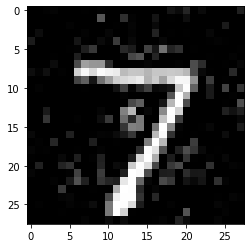

In [11]:
BEST = best + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [12]:
result=model.predict(best+x_test[0].reshape(1,784))
result[0]

array([2.9689602e-03, 1.4153644e-03, 8.5538089e-02, 5.2592212e-01,
       2.7090579e-04, 1.5223388e-02, 2.6576190e-05, 3.5122252e-01,
       1.1948012e-02, 5.4640220e-03], dtype=float32)

In [13]:
# test
count = 0
for i in range(784):
    if best[i] != 0:
        count+=1
print(count)

482


In [14]:
# test
count = 0
for i in range(784):
    if best[i] > 0.8:
        count+=1
print(count)

0


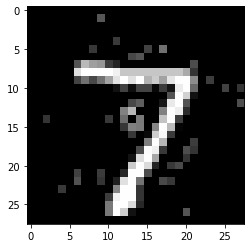

置信度： 0.8424834
[9.1767003e-04 5.8428705e-04 2.4540629e-02 1.1919443e-01 1.4927115e-04
 3.8930741e-03 9.9716972e-06 8.4248340e-01 3.5998647e-03 4.6274536e-03]
扰动程度： 4.396774529883714


In [15]:
#过滤（低强度）
import copy
x_f = copy.deepcopy(best)
for i in range(784):
    if abs(x_f[i]) < 0.2:
        x_f[i] = 0
f = x_f+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(f.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_f))

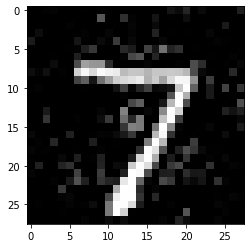

置信度： 0.50022095
[3.2277417e-03 1.2880706e-03 8.8591658e-02 3.8037843e-01 2.6989231e-04
 1.2227084e-02 2.4959374e-05 5.0022095e-01 8.8544004e-03 4.9166912e-03]
扰动程度： 5.342238182231904


In [20]:
#过滤（高强度）
import copy
x_F = copy.deepcopy(best)
for i in range(784):
    if abs(x_F[i]) > 0.6:
        x_F[i] = 0
F = x_F+x_test[0]
plt.imshow(F.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(F.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_F))

迭代: 1
置信度： 0.84129864


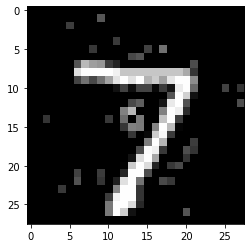

迭代: 2
置信度： 0.841192


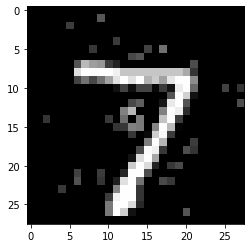

迭代: 3
置信度： 0.83890784


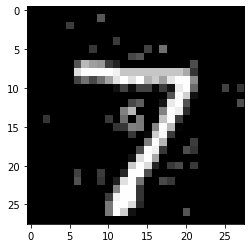

迭代: 4
置信度： 0.83617216


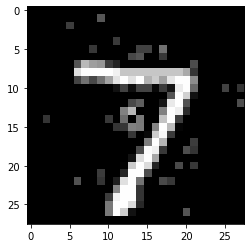

迭代: 5
置信度： 0.8350074


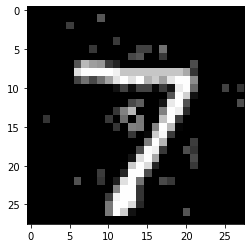

迭代: 6
置信度： 0.83116496


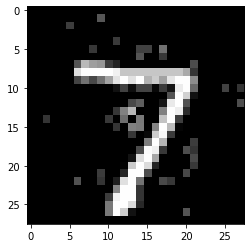

迭代: 7
置信度： 0.830711


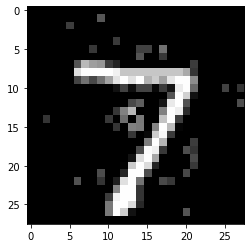

迭代: 8
置信度： 0.83026624


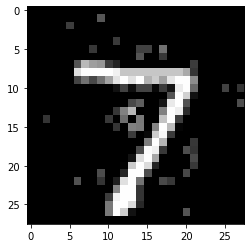

迭代: 9
置信度： 0.828436


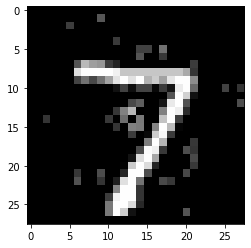

迭代: 10
置信度： 0.8282943


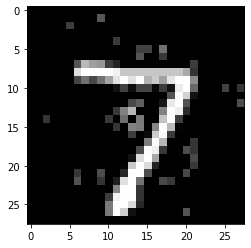

迭代: 11
置信度： 0.82604474


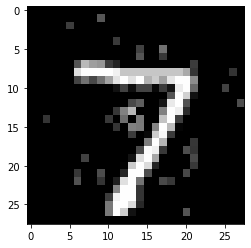

迭代: 12
置信度： 0.8249944


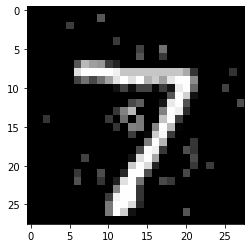

迭代: 13
置信度： 0.82432306


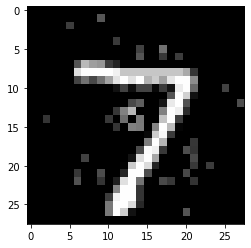

迭代: 14
置信度： 0.8240062


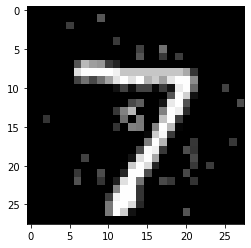

迭代: 15
置信度： 0.8228874


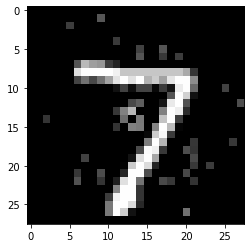

迭代: 16
置信度： 0.8202427


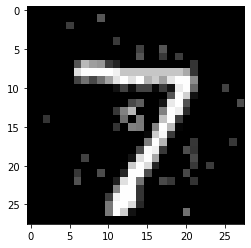

迭代: 17
置信度： 0.8156962


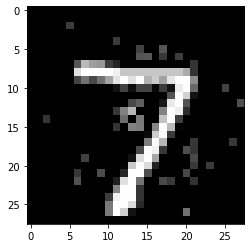

迭代: 18
置信度： 0.815118


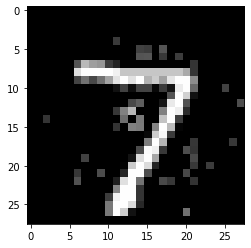

迭代: 19
置信度： 0.814871


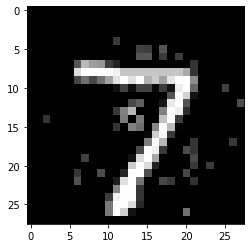

迭代: 20
置信度： 0.8114601


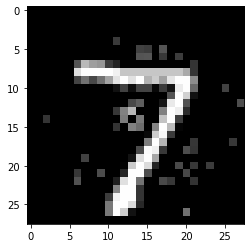

迭代: 21
置信度： 0.81128335


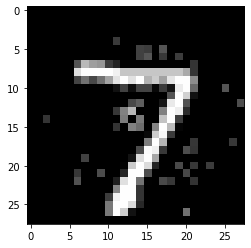

迭代: 22
置信度： 0.81112087


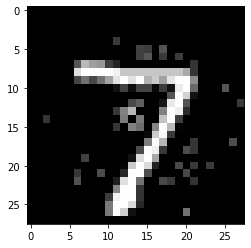

迭代: 23
置信度： 0.810064


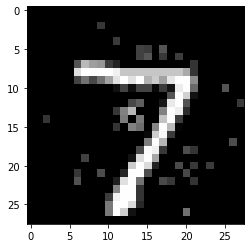

迭代: 24
置信度： 0.8041851


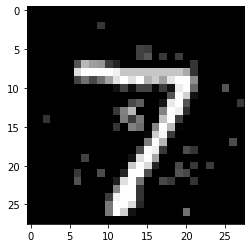

迭代: 25
置信度： 0.8022935


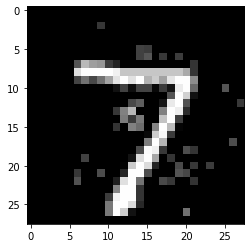

迭代: 26
置信度： 0.7984404


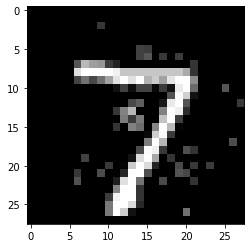

迭代: 27
置信度： 0.79821974


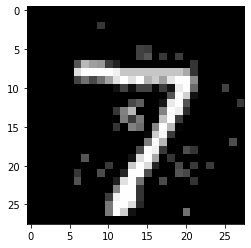

迭代: 28
置信度： 0.79584324


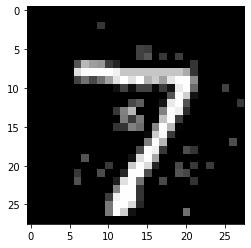

迭代: 29
置信度： 0.794954


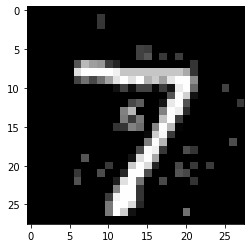

迭代: 30
置信度： 0.79467165


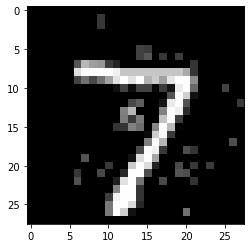

迭代失败


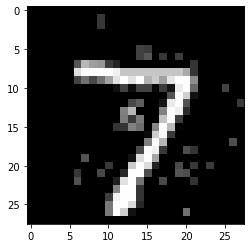

最终置信度： 0.79467165
最终扰动程度： 4.396774529883714
[1.2703206e-03 6.9075561e-04 3.4616861e-02 1.5130623e-01 1.5710102e-04
 4.6935016e-03 1.3530412e-05 7.9467165e-01 5.7824198e-03 6.7976140e-03]


In [21]:
# 改变坐标减小置信度（过滤0.2）
import copy
x_t = copy.deepcopy(x_f)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


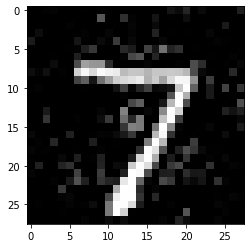

最终置信度： 0.50022095
最终扰动程度： 5.342238182231904
[3.2277417e-03 1.2880706e-03 8.8591658e-02 3.8037843e-01 2.6989231e-04
 1.2227084e-02 2.4959374e-05 5.0022095e-01 8.8544004e-03 4.9166912e-03]


In [22]:
# 改变坐标减小置信度（过滤0.6）
import copy
x_t = copy.deepcopy(x_F)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


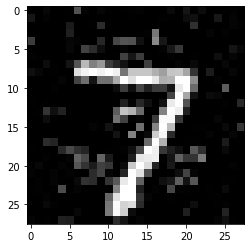

最终置信度： 0.39767227
最终扰动程度： 7.0038201815486
[3.7777259e-03 1.0443135e-03 1.1682559e-01 4.5660120e-01 1.5665211e-04
 1.2439688e-02 3.2627453e-05 3.9767227e-01 7.4698036e-03 3.9801179e-03]


In [11]:
# 改变坐标减小置信度
import copy
x_t = copy.deepcopy(BEST_X)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])